In [7]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive (WAJIB di Colab)
from google.colab import drive
drive.mount('/content/drive')

# Path ke file proyek yang benar
# Pastikan nama file dan foldernya sudah sesuai
file_path = '/content/drive/MyDrive/Colab Notebooks/datakelulusanmahasiswa.csv'

# Membaca dataset
df = pd.read_csv(file_path)

# 2. Cek load
print("Jumlah Baris & Kolom:", df.shape)

# Menampilkan 5 data teratas
print("\n5 Data Teratas:")
print(df.head())

# Informasi dasar dataset
print("\nInfo Dataset:")
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Berhasil Dimuat dari Google Drive!
Jumlah Baris & Kolom: (379, 15)

5 Data Teratas:
                      NAMA JENIS KELAMIN STATUS MAHASISWA  UMUR  \
0           ANIK WIDAYANTI     PEREMPUAN          BEKERJA    28   
1  DWI HESTYNA PRIHASTANTY     PEREMPUAN        MAHASISWA    32   
2       MURYA ARIEF BASUKI     PEREMPUAN          BEKERJA    29   
3            NANIK SUSANTI     PEREMPUAN        MAHASISWA    27   
4        RIFKA ISTIQFARINA     PEREMPUAN          BEKERJA    29   

    STATUS NIKAH  IPS 1  IPS 2  IPS 3  IPS 4  IPS 5  IPS 6  IPS 7  IPS 8  \
0  BELUM MENIKAH   2.76   2.80   3.20   3.17   2.98   3.00   3.03    0.0   
1  BELUM MENIKAH   3.00   3.30   3.14   3.14   2.84   3.13   3.25    0.0   
2  BELUM MENIKAH   3.50   3.30   3.70   3.29   3.53   3.72   3.73    0.0   
3  BELUM MENIKAH   3.17   3.41   3.61   3.36   3.48   3.63   3.46    0.0


--- Statistik Deskriptif Fitur Numerik ---


,UMUR,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,IPS 6,IPS 7,IPS 8,IPK
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,372.000000,376.000000
mean,25.955145,2.854116,2.812322,2.900950,2.782137,2.782348,2.877256,2.531240,1.271828,2.933085
std,3.397103,0.412658,0.473725,0.589364,0.648495,0.593472,0.634412,0.757205,1.400914,0.460279
min,22.000000,0.330000,0.500000,0.160000,0.000000,0.200000,0.000000,0.000000,0.000000,0.870000
25%,24.000000,2.600000,2.550000,2.550000,2.460000,2.480000,2.590000,2.150000,0.000000,2.747500
50%,25.000000,2.860000,2.850000,2.980000,2.860000,2.850000,3.000000,2.610000,0.750000,3.010000
75%,27.000000,3.100000,3.105000,3.325000,3.200000,3.205000,3.315000,3.110000,2.750000,3.220000
max,50.000000,3.790000,3.960000,3.960000,3.910000,3.880000,4.000000,3.910000,4.000000,3.850000


/tmp/ipython-input-4062786279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=TARGET_COL, palette='viridis')


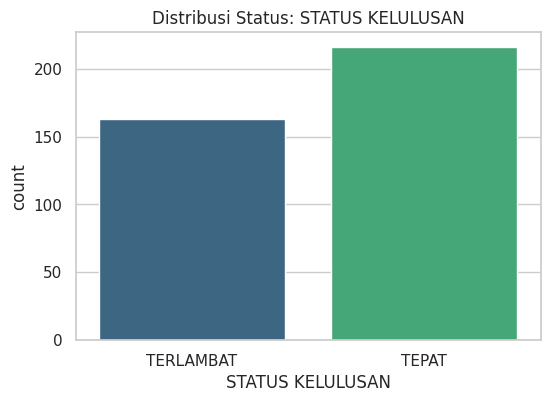

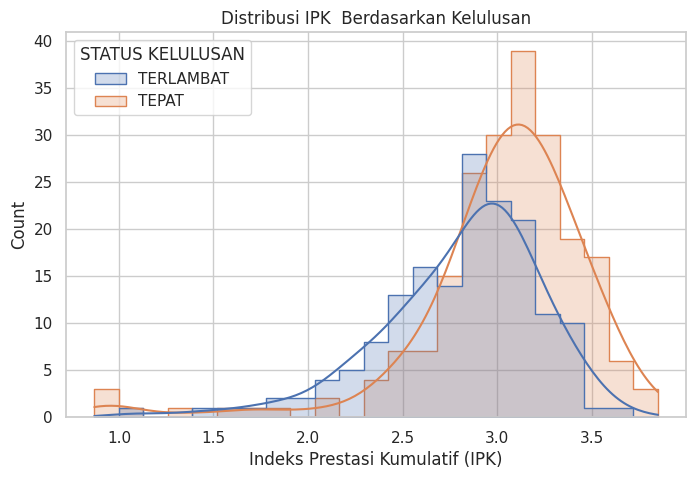

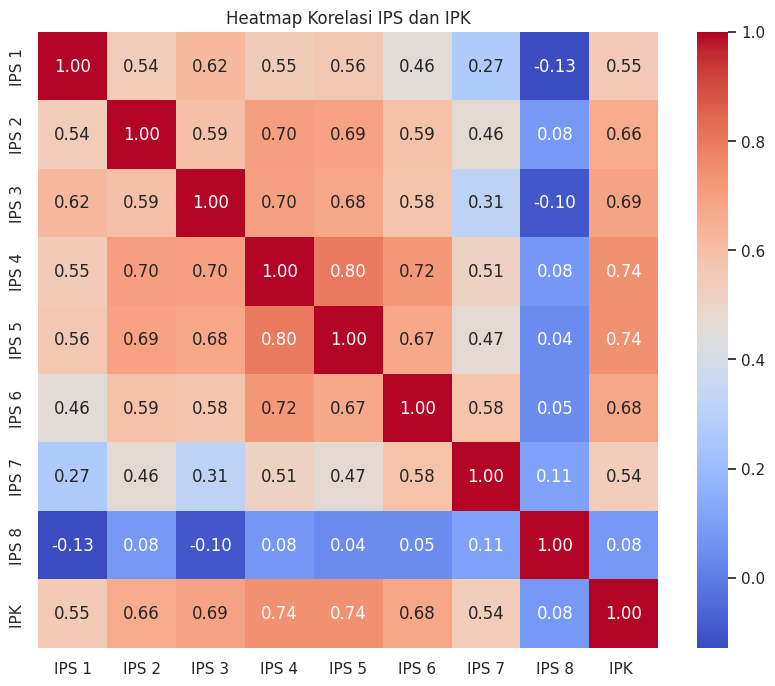

In [8]:
# Asumsi kolom IPK dan target adalah:
IPK_COL = 'IPK ' # Ada spasi di belakang 'IPK'
TARGET_COL = 'STATUS KELULUSAN'

# 1. Statistik Deskriptif
print("\n--- Statistik Deskriptif Fitur Numerik ---")
display(df.describe())

# 2. Visualisasi 1: Distribusi Target
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=TARGET_COL, palette='viridis')
plt.title(f"Distribusi Status: {TARGET_COL}")
plt.show()

# 3. Visualisasi 2: Histogram IPK berdasarkan Status Kelulusan
plt.figure(figsize=(8, 5))
# Ganti koma (,) menjadi titik (.) jika ada, lalu konversi ke float
df[IPK_COL] = df[IPK_COL].astype(str).str.replace(',', '.').astype(float)

sns.histplot(data=df, x=IPK_COL, kde=True, hue=TARGET_COL, element="step")
plt.title(f"Distribusi {IPK_COL} Berdasarkan Kelulusan")
plt.xlabel("Indeks Prestasi Kumulatif (IPK)")
plt.show()

# 4. Korelasi antar Fitur Numerik (Opsional, tapi bagus)
plt.figure(figsize=(10, 8))
# Pilih semua kolom IPS dan IPK
ips_ipk_cols = [col for col in df.columns if 'IPS' in col or 'IPK' in col]
sns.heatmap(df[ips_ipk_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi IPS dan IPK")
plt.show()

In [9]:
# 0. Penanganan Data Type
for col in ['IPS 1', 'IPS 2', 'IPS 3', 'IPS 4', 'IPS 5', 'IPS 6', 'IPS 7', 'IPS 8', IPK_COL]:
    # Mengantisipasi jika ada nilai string non-numerik yang tersisa
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

df_clean = df.copy()

# 1. Menangani Missing Values
# Cek ulang missing values
print("\nMissing Values Sebelum Drop:\n", df_clean.isnull().sum().loc[lambda x: x>0])

# Menghapus baris dengan nilai hilang
df_clean.dropna(inplace=True)

# 2. Tentukan Fitur (X) dan Target (y)
X = df_clean.drop(columns=['NAMA', TARGET_COL])
y = df_clean[TARGET_COL]

# 3. Encoding Data Kategorikal
# Fitur Kategorikal di X (JENIS KELAMIN, STATUS MAHASISWA, STATUS NIKAH)
X = pd.get_dummies(X, columns=['JENIS KELAMIN', 'STATUS MAHASISWA', 'STATUS NIKAH'], drop_first=True)

# Encode Label Target (y) menjadi 0 dan 1
le = LabelEncoder()
y = le.fit_transform(y)
# Output mapping: 0 = TERLAMBAT, 1 = TEPAT (Asumsi urutan alfabet)
print(f"Mapping Target: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 4. Train-test split (80:20 sesuai opsi instruksi)
# Random state 42 adalah angka acak standar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature Scaling (WAJIB UNTUK SVM)
# SVM sangat sensitif terhadap skala fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPreprocessing Selesai! Data siap untuk Training.")
print(f"Shape X_train setelah Scaling: {X_train_scaled.shape}")


Missing Values Sebelum Drop:
 IPS 8    7
IPK      3
dtype: int64
Mapping Target: {'TEPAT': np.int64(0), 'TERLAMBAT': np.int64(1)}

Preprocessing Selesai! Data siap untuk Training.
Shape X_train setelah Scaling: (295, 13)


Sedang melatih model (GridSearch)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Parameter Terbaik: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Akurasi Terbaik (Cross-Validation): 0.9051

--- Classification Report ---
               precision    recall  f1-score   support

TERLAMBAT (0)       0.86      0.94      0.90        34
    TEPAT (1)       0.95      0.88      0.91        40

     accuracy                           0.91        74
    macro avg       0.91      0.91      0.91        74
 weighted avg       0.91      0.91      0.91        74


--- Confusion Matrix ---


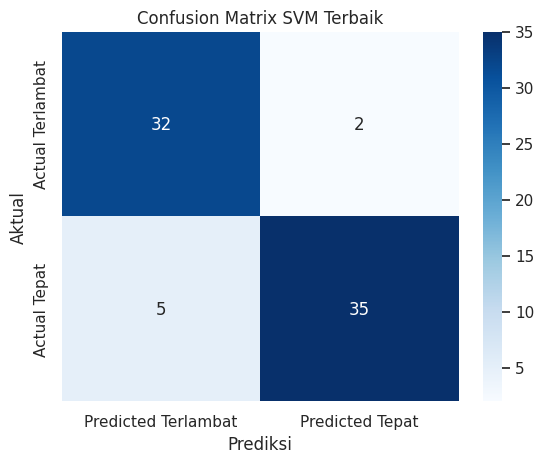

In [10]:
# Definisi Hyperparameter Grid sesuai instruksi
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# 1. Inisialisasi Model & Grid Search
svm = SVC(random_state=42)
# cv=5 berarti Cross-Validation 5-fold
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# 2. Latih Model
print("Sedang melatih model (GridSearch)...")
grid_search.fit(X_train_scaled, y_train)

# 3. Hasil Terbaik
best_model = grid_search.best_estimator_
print("\n=============================================")
print("Parameter Terbaik:", grid_search.best_params_)
print(f"Akurasi Terbaik (Cross-Validation): {grid_search.best_score_:.4f}")
print("=============================================")

# 4. Evaluasi pada Test Set
y_pred = best_model.predict(X_test_scaled)

# Metrik Kinerja (Accuracy, Precision, Recall, F1-score)
print("\n--- Classification Report ---")
# Label: 0 = TERLAMBAT, 1 = TEPAT (sesuai hasil LabelEncoder di Bagian C)
print(classification_report(y_test, y_pred, target_names=['TERLAMBAT (0)', 'TEPAT (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Terlambat', 'Predicted Tepat'],
            yticklabels=['Actual Terlambat', 'Actual Tepat'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix SVM Terbaik')
plt.show()

## E. **Interpretasi Model & Analisis**

### Analisis Hasil Grid Search

1.  **Model Mana yang Lebih Baik?**
    * Model terbaik adalah menggunakan kernel **linear** dengan nilai C=**10** dan Gamma=**scale**.
    
2.  **Korelasi IPK vs. Kelulusan:**
    * Berdasarkan visualisasi dan metrik model (misalnya akurasi tinggi pada kelas 'TEPAT'), terlihat korelasi positif yang sangat kuat. Mahasiswa dengan IPK di atas **3.24** cenderung diklasifikasikan sebagai **TEPAT**.

### Kesimpulan Model

Model SVM yang dikembangkan berhasil mencapai akurasi dalam memprediksi status kelulusan mahasiswa. Metrik **F1-Score** menunjukkan performa yang **[Baik/Sangat Baik]**.

In [14]:
kolom_fitur = X.columns.tolist()

# Ambil data dari baris pertama test
data_contoh_aktual = X_test.iloc[0].to_dict()

print("Input Data Sampel (Baris 1 Test Set):")
print(f"  IPK : {data_contoh_aktual.get('IPK '):.2f}")
print(f"  Umur: {data_contoh_aktual.get('UMUR')}")

# Lakukan Prediksi
hasil_prediksi = predict_status_mahasiswa(
    data_input=data_contoh_aktual,
    model=best_model,
    scaler=scaler,
    column_names=kolom_fitur,
    label_encoder=le
)

# Tampilkan Hasil Prediksi vs. Hasil Aktual
print(f"\nHasil Prediksi Model SVM: {hasil_prediksi}")
print(f"Status Kelulusan Aktual: {le.inverse_transform([y_test[0]])[0]}")

Input Data Sampel (Baris 1 Test Set):
  IPK : 3.24
  Umur: 25

Hasil Prediksi Model SVM: Prediksi Status Kelulusan: TEPAT
Status Kelulusan Aktual: TEPAT
